In [2]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pickle
# import torch
import pdb

from collections import Counter
from gap_statistic import OptimalK
from scipy import stats, cluster
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

from utils.clustering_utils import *
from utils.conformal_utils import *
from utils.experiment_utils import *

%load_ext autoreload
%autoreload 2

In [69]:
t = (0,1,2,3)
t[0], t[2], t[3]

(0, 2, 3)

## Testing null that there is one cluster

In [2]:
from sklearn import metrics 

def _get_cluster_fit(true_class_scores, labels, num_classes, num_clusters):
    
    # Compute embeddings
    q = [0.5, 0.6, 0.7, 0.8, 0.9]
    embeddings = np.zeros((num_classes, len(q)))
    for i in range(num_classes):
        class_i_scores = true_class_scores[labels==i]
        embeddings[i,:] = quantile_embedding(class_i_scores, q=q)

    kmeans = KMeans(n_clusters=num_clusters, random_state=0, n_init=10).fit(embeddings)
    
# #     # OPTION 1: (Doesn't work well) Sum of squared distances of samples to their closest cluster center
#     cluster_fit_metric = kmeans.inertia_

#       # OPTION 2: Silhouette score
#     cluster_labels = kmeans.labels_
#     cluster_fit_metric = metrics.silhouette_score(embeddings, cluster_labels, metric='euclidean')
    
    # OPTION 3: avg L1 distance of quantiles of original scores
    # Group scores by cluster
    list_of_cluster_scores = []
    for i in range(num_clusters):
        clusteri_classes = np.argwhere(cluster_labels == i)
        clusteri_scores = true_class_scores[np.in1d(labels, clusteri_classes)]
        list_of_cluster_scores.append(clusteri_scores)
    cluster_fit_metric = compute_avg_distance_between_quantiles(list_of_cluster_scores, q=q)
    
    return cluster_fit_metric


def test_one_cluster_null(scores, labels, num_classes, num_clusters=2, num_trials=100, seed=0):
    np.random.seed(seed)
    
    if len(scores.shape) > 1:
        true_class_scores = get_true_class_conformal_score(scores, labels)
    else:
        true_class_scores = scores
    
    # Compute metric using true class labels
    observed_metric = _get_cluster_fit(true_class_scores, labels, num_classes, num_clusters)   
    
    metrics_under_null = np.zeros((num_trials,))
    permuted_labels = np.copy(labels)
    for i in range(num_trials):
        # Randomly permute labels
        np.random.shuffle(permuted_labels)
        
        # Compute metric for each random permutation 
        metrics_under_null[i] = _get_cluster_fit(true_class_scores, permuted_labels, num_classes, num_clusters)
        
    # Compute fraction of results under null that yield a better clustering metric 
    # than the observed value 
    num_better = np.sum(metrics_under_null < observed_metric) # Lower inertia = better clustering
    p_value = num_better / num_trials
    
    print('Observed metric:', observed_metric)
    print('Metric under null:', metrics_under_null)
    
    print(f'Probability of observing a smaller metric under null hypothesis of one cluster: {p_value}',
          f'({num_better} out of {num_trials} trials)')
    
    return p_value

In [3]:
# # Version 2: operate directly on scores rather than embeddings [DOES NOT WORK]

def compute_avg_distance_between_quantiles(list_of_arrs, q=[0.5, 0.6, 0.7, 0.8, 0.9]):
    '''
    Computes the L1 distance between quantiles q between each pair of groups
    in list_of_arrs and then takes average across all pairs
    
    Input:
        list_of_arrs: length-n list of arrays. list_of_arrs[i] contains 
        samples from group i
    '''
    n_groups = len(list_of_arrs)
    
    dists = []
    for i in range(n_groups):
        
        groupi_quantiles = np.quantile(list_of_arrs[i], q)
        
        for j in range(i+1, n_groups):
            groupj_quantiles = np.quantile(list_of_arrs[j], q)
            
            dist_ij = np.sum(np.abs(groupi_quantiles - groupj_quantiles))
            dists.append(dist_ij)
            
    avg_dist = sum(dists) / len(dists)
    return avg_dist

# def cluster_and_group_scores_by_cluster(true_class_scores, labels, num_clusters):
    
#     # Compute embeddings
#     q = [0.5, 0.6, 0.7, 0.8, 0.9]
#     embeddings = np.zeros((num_classes, len(q)))
#     for i in range(num_classes):
#         class_i_scores = true_class_scores[labels==i]
#         embeddings[i,:] = quantile_embedding(class_i_scores, q=q)

#     # Cluster
#     kmeans = KMeans(n_clusters=num_clusters, random_state=0, n_init=10).fit(embeddings)
#     cluster_labels = kmeans.labels_
    
#     # Group scores by cluster
#     list_of_cluster_scores = []
#     for i in range(num_clusters):
#         clusteri_classes = np.argwhere(cluster_labels == i)
#         clusteri_scores = true_class_scores[np.in1d(labels, clusteri_classes)]
#         list_of_cluster_scores.append(clusteri_scores)
        
#     return list_of_cluster_scores 

# def test_one_cluster_null_v2(scores, labels, num_classes, num_clusters=2, num_trials=100, seed=0):
#     np.random.seed(seed)
#     q=[0.5, 0.6, 0.7, 0.8, 0.9]
    
#     if len(scores.shape) > 1:
#         true_class_scores = get_true_class_conformal_score(scores, labels)
#     else:
#         true_class_scores = scores
    
#     # Compute metric using true class labels
#     list_of_cluster_scores = cluster_and_group_scores_by_cluster(true_class_scores, labels, num_clusters)
#     observed_metric = compute_avg_distance_between_quantiles(list_of_cluster_scores, q=q)
    
# #     print('OBS', list_of_cluster_scores)
    
#     metrics_under_null = np.zeros((num_trials,))
#     for i in range(num_trials):
#         # Split scores into num_clusters randomly sized chunks
#         # - Randomly select a probability vector p
#         unifs = np.random.rand(num_clusters)
#         p = unifs / unifs.sum()
        
#         # - Assign classes based on p
#         rand_clusters = np.random.choice(num_clusters, size=len(labels), p=p)
#         list_of_cluster_scores = [true_class_scores[rand_clusters==i] for i in range(num_clusters)]
        
# #         print('SIM', list_of_cluster_scores)
        
#         # Compute metric for each random permutation 
#         metrics_under_null[i] = compute_avg_distance_between_quantiles(list_of_cluster_scores, q=q)
        
# #         assert False
        
#     # Compute fraction of results under null that yield a better clustering metric 
#     # than the observed value 
#     num_better = np.sum(metrics_under_null < observed_metric) # Lower inertia = better clustering
#     p_value = num_better / num_trials
    
#     print('Observed metric:', observed_metric)
#     print('Metric under null:', metrics_under_null)
    
#     print(f'Probability of observing a smaller metric under null hypothesis of one cluster: {p_value}',
#           f'({num_better} out of {num_trials} trials)')
    
#     return p_value

### Test on Enron

In [24]:
# Load data
alpha = .1
n_totalcal = 20 # Total number of calibration points (= # clustering examples + # conformal calibration examples)

# Enron - BERT
softmax_path = "../class-conditional-conformal-datasets/notebooks/.cache/email_softmax_bert_ntrain=500.npy"
labels_path = "../class-conditional-conformal-datasets/notebooks/.cache/email_labels_bert_ntrain=500.npy"

softmax_scores = np.load(softmax_path)
labels = np.load(labels_path)

num_classes = labels.max() + 1

In [35]:
n_clustering = 5
num_clusters = 3

score_function = 'softmax'


if score_function == 'softmax':
    scores_all = 1 - softmax_scores
    
# Split into clustering+calibration data and validation data
totalcal_scores_all, totalcal_labels, val_scores_all, val_labels = split_X_and_y(scores_all, labels, n_totalcal, num_classes=num_classes, seed=7)

# 0) Split data between clustering and calibration
scores1_all, labels1, scores2_all, labels2 = split_X_and_y(totalcal_scores_all, 
                                                       totalcal_labels, 
                                                       n_clustering, 
                                                       num_classes=num_classes, 
                                                       seed=0)

# 1) Test k chosen using ad-hoc heuristic
test_one_cluster_null(scores1_all, labels1, num_classes, num_clusters=num_clusters, num_trials=100, seed=0)

Observed metric: 0.7757373115323073
Metric under null: [0.45151132 0.32432147 0.73205709 0.49116746 0.23389451 0.43058253
 0.39253624 0.46617533 0.30909889 0.80397174 0.67749834 0.82024545
 0.70272406 0.51445724 0.29029255 0.35221266 0.57012928 0.90003647
 0.44544204 0.27693843 0.3671603  0.45065448 1.53850399 0.41744018
 0.30732166 0.39344402 0.44805636 0.41908243 0.69618777 1.26120738
 0.33152527 0.76047233 0.36360908 0.62614049 1.09884185 1.90902774
 0.30035567 1.11888252 0.72788612 0.42156505 0.35764796 1.29340075
 0.34450692 0.98043791 0.45037955 1.12890606 0.27056832 0.36193183
 0.21872629 0.29598139 0.54984367 0.41075872 0.72651938 0.34303703
 0.36823209 0.64185557 0.29999708 0.42316498 0.61647996 0.51725537
 0.32094597 0.39102757 0.61793278 0.40789829 0.32464459 0.57148852
 0.41716768 0.4598939  0.60976683 0.54144907 0.29602576 0.98729637
 0.46410569 0.36812143 0.31888791 0.40146241 0.38875357 0.44211959
 0.78028015 0.32953237 0.33911119 0.44698013 0.54953297 0.25002406
 0.3171

0.85

### Synthetic test

In [41]:
# Generate synthetic data (2 clusters of classes. One is Beta(1,1) and the other is Beta(3,.5))
num_classes = 100
n_clustering = 5

true_class_scores = np.zeros((num_classes * n_clustering,))
labels = np.zeros((num_classes * n_clustering,))
for i in range(num_classes):
    # Each class is in Cluster 0 or Cluster 1 with equal probability 
    if np.random.rand() > 0.5:
#         samples = np.random.normal(0,1, size=n_clustering)
        samples = np.random.beta(1,1, size=n_clustering)
    else:
#         samples = np.random.normal(0,1, size=n_clustering)
        samples = np.random.beta(3,.5, size=n_clustering)
        
    true_class_scores[i*n_clustering:(i+1)*n_clustering] = samples 
        
    labels[i*n_clustering:(i+1)*n_clustering] = i
    
# Test k=2 vs. k=1
test_one_cluster_null(true_class_scores, labels, num_classes, num_clusters=2, num_trials=100, seed=0)

Observed metric: 1.8425164414927768
Metric under null: [0.86187347 0.87179594 0.9484072  0.97205673 0.79611811 1.02954443
 0.89338773 0.71414115 0.98365402 1.04118377 0.99117361 0.78590661
 1.01256282 1.15610226 0.81320829 0.95973893 0.8134263  1.00787498
 0.95751718 0.85664703 0.87029901 1.17421971 1.30395335 0.93433334
 1.00179653 0.94041709 0.92147795 1.04283627 0.8346762  0.8681899
 0.90155756 1.05764202 1.00417968 0.92311172 0.98390793 0.76538461
 0.84297992 0.90925041 1.2775974  0.90477097 0.92095417 0.9894978
 1.06825953 0.90673281 0.98330046 1.21902753 0.94558885 1.03282373
 0.79267238 1.12088129 0.96915478 0.84036883 1.10097703 0.94188114
 1.00316437 1.40257299 0.86751182 0.96285074 0.96662509 1.217582
 0.86403219 0.8022638  1.32255051 1.05810676 0.81474648 0.71010339
 1.31229166 0.88728205 1.01444249 0.91783796 0.90669439 1.00289909
 0.93147397 1.06774802 0.92460432 1.18133069 0.958657   1.13707261
 1.02927718 1.05152956 0.94845884 0.79241753 0.84040538 0.82922434
 0.94035698

1.0

Correct p-value? e.g., seed=5 gives p=.11 but other times it is < .03. Should maybe increase num_trials beyond 100 for more stability

[silhouette] With 1000 trials and 100 classes, Beta (1,1), Beta(3, .5). Higher score = better cluster

P(lower) is 
* 0.986
* 1.0
* 0.963
* 0.992

[inertia] With 1000 trials and 100 classes, Beta (1,1), Beta(3, .5). Lower score = better cluster. But does not account for the fact that randomizing results in embeddings that are closer together overall

P(lower) is 
* 0.998 but we actually want this to be close to 0!!!


[inertia] With 100 trials and 100 classes, Normal(0,1), Normal(10,1). 
P(lower is)
* 0.0


In conclusion, silhouette is better for our use case because it is standardized. 

### Test on ImageNet - softmax

In [48]:
# Load data
alpha = .1
n_totalcal = 10 # Total number of calibration points (= # clustering examples + # conformal calibration examples)

# ImageNet
softmax_path = '/home/tding/data/finetuned_imagenet/imagenet_train_subset_softmax.npy'
labels_path = '/home/tding/data/finetuned_imagenet/imagenet_train_subset_labels.npy'
softmax_scores = np.load(softmax_path)
labels = np.load(labels_path)

num_classes = labels.max() + 1

In [49]:
score_function = 'softmax'


if score_function == 'softmax':
    scores_all = 1 - softmax_scores
    
# Split into clustering+calibration data and validation data
totalcal_scores_all, totalcal_labels, val_scores_all, val_labels = split_X_and_y(scores_all, labels, n_totalcal, num_classes=num_classes, seed=7)

In [52]:
n_clustering = 9
num_clusters = 50

# 0) Split data between clustering and calibration
scores1_all, labels1, scores2_all, labels2 = split_X_and_y(totalcal_scores_all, 
                                                       totalcal_labels, 
                                                       n_clustering, 
                                                       num_classes=num_classes, 
                                                       seed=0)

# 1) Test k chosen using ad-hoc heuristic
test_one_cluster_null(scores1_all, labels1, num_classes, num_clusters=num_clusters, num_trials=100, seed=0)

Observed metric: 1.5014748257909503
Metric under null: [1.34337364 1.34823567 1.35910352 1.33588652 1.30077732 1.35194303
 1.34619584 1.38380463 1.40494304 1.34793517 1.2848282  1.35615271
 1.33192835 1.36943094 1.31527481 1.37436384 1.34828231 1.32104032
 1.36042272 1.37184055 1.34199021 1.31849631 1.37028395 1.327778
 1.3274847  1.35686893 1.33207267 1.36747525 1.33284109 1.34138328
 1.3834615  1.31482878 1.39302892 1.31821949 1.35974126 1.34644293
 1.3061125  1.33753944 1.31653484 1.36780583 1.30645252 1.34614379
 1.34176885 1.28651441 1.35002671 1.28216354 1.34035147 1.32556597
 1.31701139 1.33371759 1.35105503 1.35966238 1.28096273 1.35130207
 1.32273301 1.37076126 1.30632771 1.39565656 1.30777287 1.30715527
 1.36965516 1.36329009 1.33515404 1.36878446 1.36936872 1.34348023
 1.32248072 1.34989239 1.3394125  1.36238889 1.33879649 1.32879162
 1.34444194 1.29470788 1.31599475 1.38324171 1.37345336 1.38477182
 1.35027722 1.32980355 1.32493293 1.40223242 1.34168502 1.36346118
 1.342081

1.0

### Test on ImageNet - APS

In [54]:
# Load data
alpha = .1
n_totalcal = 10 # Total number of calibration points (= # clustering examples + # conformal calibration examples)

# ImageNet
APS_path = '/home/tding/data/finetuned_imagenet/imagenet_train_subset_APS.npy'
labels_path = '/home/tding/data/finetuned_imagenet/imagenet_train_subset_labels.npy'
APS_scores = np.load(APS_path)
labels = np.load(labels_path)

num_classes = labels.max() + 1

In [56]:
scores_all = APS_scores

# Split into clustering+calibration data and validation data
totalcal_scores_all, totalcal_labels, val_scores_all, val_labels = split_X_and_y(scores_all, labels, n_totalcal, num_classes=num_classes, seed=7)

In [62]:
n_clustering = 5
num_clusters = 5

# 0) Split data between clustering and calibration
scores1_all, labels1, scores2_all, labels2 = split_X_and_y(totalcal_scores_all, 
                                                       totalcal_labels, 
                                                       n_clustering, 
                                                       num_classes=num_classes, 
                                                       seed=0)

# 1) Test k chosen using ad-hoc heuristic
test_one_cluster_null(scores1_all, labels1, num_classes, num_clusters=num_clusters, num_trials=1000, seed=2)

Observed metric: 1.2852707739201041
Metric under null: [1.14475778 1.08360021 1.10488874 1.08136564 1.05255599 1.13209695
 1.07458268 1.08542867 1.24344913 1.08505069 1.14587061 1.19985392
 1.26749752 1.08098534 1.07252618 1.30788533 1.17926092 1.15843491
 1.13979329 1.11182036 1.25768946 1.07926848 1.11760908 1.21430416
 1.10692022 1.13669431 1.11049796 1.16183259 1.14150135 1.11540434
 1.14976526 1.09699924 1.12444508 1.12418124 1.24842408 1.14833131
 1.09286472 1.22571067 1.11569564 1.13573816 1.29479786 1.1317263
 1.11881283 1.10208476 1.1365222  1.21136059 1.08514501 1.13615582
 1.14465668 1.15464564 1.18747472 1.13685776 1.23081858 1.12058058
 1.11648811 1.12578767 1.15818624 1.092296   1.2192506  1.0831188
 1.09661343 1.28469823 1.11335996 1.07396858 1.09910141 1.09966898
 1.23482948 1.10342615 1.10705648 1.12493029 1.20657005 1.16475902
 1.23133083 1.07055279 1.05491229 1.30033174 1.09313835 1.07284801
 1.10334683 1.28130213 1.26155882 1.13898708 1.14907569 1.29483329
 1.070818

0.954

n_clustering = 5
num_clusters = 5

seed=0
Probability of observing a smaller metric under null hypothesis of one cluster: 0.949 (949 out of 1000 trials)
seed=1
Probability of observing a smaller metric under null hypothesis of one cluster: 0.949 (949 out of 1000 trials)
seed=2
Probability of observing a smaller metric under null hypothesis of one cluster: 0.954 (954 out of 1000 trials)

## Test

In [33]:
alpha = .1
n_totalcal = 20 # Total number of calibration points (= # clustering examples + # conformal calibration examples)


# Enron - BERT
softmax_path = "../class-conditional-conformal-datasets/notebooks/.cache/email_softmax_bert.npy"
labels_path = "../class-conditional-conformal-datasets/notebooks/.cache/email_labels_bert.npy"

In [7]:
## 1. Get data ============================
print('Loading softmax scores and labels...')

softmax_scores = np.load(softmax_path)
labels = np.load(labels_path)

num_classes = labels.max() + 1

Loading softmax scores and labels...


In [26]:
# # for score_function in ['softmax', 'APS', 'RAPS']:
# n_clustering_list = (np.array([.3, .5, .7, .9]) * n_totalcal).astype(np.int32)


# for score_function in ['softmax', 'APS']:
    
#     print(f'====== score_function={score_function} ======')
    
#     print('Computing conformal score...')
#     if score_function == 'softmax':
#         scores_all = 1 - softmax_scores
#     elif score_function == 'APS':
#         scores_all = get_APS_scores_all(softmax_scores, randomize=True)
#     elif score_function == 'RAPS': 
        
#         # RAPS hyperparameters (currently using ImageNet defaults)
#         lmbda = .01 
#         kreg = 5
        
#         scores_all = get_RAPS_scores_all(softmax_scores, lmbda, kreg, randomize=True)
#     else:
#         raise Exception('Undefined score function')


#     print('Splitting data...')
#     # Split into clustering+calibration data and validation data
#     totalcal_scores_all, totalcal_labels, val_scores_all, val_labels = split_X_and_y(scores_all, labels, n_totalcal, num_classes=num_classes, seed=0)

#     for n_clustering in n_clustering_list:
            
#         # 0) Split data 
#         scores1_all, labels1, scores2_all, labels2 = split_X_and_y(totalcal_scores_all, 
#                                                            totalcal_labels, 
#                                                            n_clustering, 
#                                                            num_classes=num_classes, 
#                                                            seed=0)

#         # 1) Compute embedding for each class
#         embeddings = embed_all_classes(scores1_all, labels1, q=[0.5, 0.6, 0.7, 0.8, 0.9])

#         # 2) Do k-means with different k's
#         for num_clusters in np.arange(1,13):
#             kmeans = KMeans(n_clusters=num_clusters, random_state=0, n_init=10).fit(embeddings)
#             cluster_assignments = kmeans.labels_  

#             # Print cluster sizes
#             print(f'[n_clustering={n_clustering}, num_clusters={num_clusters}] Cluster sizes:', [x[1] for x in Counter(cluster_assignments).most_common()])


====== score_function=softmax ======
Computing conformal score...
Splitting data...
[n_clustering=3, num_clusters=1] Cluster sizes: [109]
[n_clustering=3, num_clusters=2] Cluster sizes: [87, 22]
[n_clustering=3, num_clusters=3] Cluster sizes: [74, 28, 7]
[n_clustering=3, num_clusters=4] Cluster sizes: [62, 26, 17, 4]
[n_clustering=3, num_clusters=5] Cluster sizes: [61, 26, 14, 6, 2]
[n_clustering=3, num_clusters=6] Cluster sizes: [59, 22, 17, 5, 4, 2]
[n_clustering=3, num_clusters=7] Cluster sizes: [59, 16, 13, 13, 4, 2, 2]
[n_clustering=3, num_clusters=8] Cluster sizes: [59, 16, 13, 13, 3, 2, 2, 1]
[n_clustering=3, num_clusters=9] Cluster sizes: [59, 16, 12, 11, 3, 3, 2, 2, 1]
[n_clustering=3, num_clusters=10] Cluster sizes: [36, 23, 16, 12, 11, 3, 3, 2, 2, 1]
[n_clustering=3, num_clusters=11] Cluster sizes: [31, 28, 16, 11, 8, 4, 3, 3, 2, 2, 1]
[n_clustering=3, num_clusters=12] Cluster sizes: [36, 23, 15, 12, 7, 3, 3, 3, 2, 2, 2, 1]
[n_clustering=5, num_clusters=1] Cluster sizes: [10

In [31]:
# for score_function in ['softmax', 'APS', 'RAPS']:
for score_function in ['softmax', 'APS']:
    
    print(f'====== score_function={score_function} ======')
    
    print('Computing conformal score...')
    if score_function == 'softmax':
        scores_all = 1 - softmax_scores
    elif score_function == 'APS':
        scores_all = get_APS_scores_all(softmax_scores, randomize=True)
    elif score_function == 'RAPS': 
        
        # RAPS hyperparameters (currently using ImageNet defaults)
        lmbda = .01 
        kreg = 5
        
        scores_all = get_RAPS_scores_all(softmax_scores, lmbda, kreg, randomize=True)
    else:
        raise Exception('Undefined score function')


    print('Splitting data...')
    # Split into clustering+calibration data and validation data
    totalcal_scores_all, totalcal_labels, val_scores_all, val_labels = split_X_and_y(scores_all, labels, n_totalcal, num_classes=num_classes, seed=0)


    qhats, preds, class_cov_gap, set_size_metrics = clustered_conformal(totalcal_scores_all, totalcal_labels,
                                                                        alpha,
                                                                        tune_parameters=True,
                                                                        n_clustering=None, num_clusters=None,
                                                                        val_scores=val_scores_all, val_labels=val_labels)
    print('[Clustered conformal] Class coverage gap:', class_cov_gap)
    print('[Clustered conformal] Set size metrics', set_size_metrics)

====== score_function=softmax ======
Computing conformal score...
Splitting data...
Best n_clustering: 5
Best num_clusters: 3
Cluster sizes: [88, 15, 6]
[Clustered conformal] Class coverage gap: 3.131593054758153
[Clustered conformal] Set size metrics {'mean': 38.618291323892166, '[.25, .5, .75, .9] quantiles': array([30., 41., 49., 55.])}
====== score_function=APS ======
Computing conformal score...
Splitting data...
Best n_clustering: 9
Best num_clusters: 5
Cluster sizes: [30, 23, 23, 18, 15]
[Clustered conformal] Class coverage gap: 6.701743518999062
[Clustered conformal] Set size metrics {'mean': 66.72654921553159, '[.25, .5, .75, .9] quantiles': array([62., 71., 76., 80.])}


# Test ad-hoc heuristic

For n_totalcal=10, num_classes=108 our heuristic says 5 points for clustering, 3 clusters.



This is a hard task since we only have 1,080 total calibration points

In [43]:
n_clustering = 5
num_clusters = 5

In [44]:
# for score_function in ['softmax', 'APS', 'RAPS']:
for score_function in ['softmax', 'APS']:
    
    print(f'====== score_function={score_function} ======')
    
    print('Computing conformal score...')
    if score_function == 'softmax':
        scores_all = 1 - softmax_scores
    elif score_function == 'APS':
        scores_all = get_APS_scores_all(softmax_scores, randomize=True)
    elif score_function == 'RAPS': 
        
        # RAPS hyperparameters (currently using ImageNet defaults)
        lmbda = .01 
        kreg = 5
        
        scores_all = get_RAPS_scores_all(softmax_scores, lmbda, kreg, randomize=True)
    else:
        raise Exception('Undefined score function')


    print('Splitting data...')
    # Split into clustering+calibration data and validation data
    totalcal_scores_all, totalcal_labels, val_scores_all, val_labels = split_X_and_y(scores_all, labels, n_totalcal, num_classes=num_classes, seed=0)


    qhats, preds, class_cov_gap, set_size_metrics = _clustered_conformal(totalcal_scores_all, totalcal_labels,
                                                                        alpha,
                                                                        n_clustering=n_clustering, num_clusters=num_clusters,
                                                                        val_scores=val_scores_all, val_labels=val_labels)
    print('[Clustered conformal] Class coverage gap:', class_cov_gap)
    print('[Clustered conformal] Set size metrics', set_size_metrics)

====== score_function=softmax ======
Computing conformal score...
Splitting data...
Cluster sizes: [81, 19, 7, 1, 1]
[Clustered conformal] Class coverage gap: 2.1080014658611397
[Clustered conformal] Set size metrics {'mean': 37.021779144955744, '[.25, .5, .75, .9] quantiles': array([29., 40., 47., 53.])}
====== score_function=APS ======
Computing conformal score...
Splitting data...
Cluster sizes: [29, 27, 27, 20, 6]
[Clustered conformal] Class coverage gap: 2.602582134356466
[Clustered conformal] Set size metrics {'mean': 39.76418858685417, '[.25, .5, .75, .9] quantiles': array([32., 43., 51., 56.])}


In [47]:
# Scratch

import glob

file_names = sorted(glob.glob('.cache/enron_n=10/softmax/*.pkl'))
file_names

['.cache/enron_n=10/softmax/seed=0_allmetrics.pkl',
 '.cache/enron_n=10/softmax/seed=1_allmetrics.pkl',
 '.cache/enron_n=10/softmax/seed=2_allmetrics.pkl',
 '.cache/enron_n=10/softmax/seed=3_allmetrics.pkl',
 '.cache/enron_n=10/softmax/seed=4_allmetrics.pkl']

# Class coverage gap excluding classes in smallest cluster

Compute for Clustered Conformal and also baselines

In [90]:
results.keys()

dict_keys(['standard', 'classwise', 'always_cluster', 'smart_cluster'])

In [91]:
metrics_dict = results['always_cluster'][1]
alpha = 0.1

In [99]:
def large_clusters_class_cov_gap(metrics_dict, classes_in_smallest_cluster, alpha):

    raw_class_coverages = metrics_dict['raw_class_coverages']
    num_classes = len(raw_class_coverages)

    # Compute average class coverage across classes not in smallest cluster
    all_classes = np.arange(num_classes)
    classes_not_in_smallest_cluster = np.setdiff1d(all_classes, classes_in_smallest_cluster)
    large_cluster_class_covs = raw_class_coverages[classes_not_in_smallest_cluster]
    large_cluster_class_cov_gap = np.mean(np.abs(large_cluster_class_covs - (1-alpha))) 

    return large_cluster_class_cov_gap

def smallest_clusters_class_cov_gap(metrics_dict, classes_in_smallest_cluster, alpha):

    raw_class_coverages = metrics_dict['raw_class_coverages']
    num_classes = len(raw_class_coverages)

    # Compute average class coverage across classes not in smallest cluster
    smallest_cluster_class_covs = raw_class_coverages[classes_in_smallest_cluster]
    smallest_cluster_class_cov_gap = np.mean(np.abs(smallest_cluster_class_covs - (1-alpha))) 

    return smallest_cluster_class_cov_gap


def get_classes_in_smallest_cluster(always_cluster_metrics_dict):
    '''
    Input:
        - always_cluster_metrics_dict: metrics dict produced by always_cluster method,
        which will always contain cluster_assignments 
    '''
    cluster_assignments = metrics_dict['cluster_assignments']

    num_classes = len(cluster_assignments)
    smallest_cluster = Counter(cluster_assignments).most_common()[-1][0]
    classes_in_smallest_cluster = np.where(cluster_assignments == smallest_cluster)[0] 

    print('Total number of classes:', num_classes)
    print('Number of classes in smallest cluster:', len(classes_in_smallest_cluster))

    return classes_in_smallest_cluster


alpha = 0.1

for seed in [0,1,2,3,4]:
    
    pth = f'/home/tding/code/class-conditional-conformal/.cache/paper/places365/n_totalcal=10/score=softmax/seed={seed}_allresults.pkl'
    with open(pth, 'rb') as f:
        results = pickle.load(f)

    always_cluster_metrics_dict = results['always_cluster'][1]
    classes_in_smallest_cluster = get_classes_in_smallest_cluster(always_cluster_metrics_dict)

    print('\n=== Average class coverage across classes not in smallest cluster ===')
    for method in results.keys():
        metrics_dict = results[method][1]
        large_cluster_class_cov_gap = large_clusters_class_cov_gap(metrics_dict, classes_in_smallest_cluster, alpha)
        print(f'{method}: {large_cluster_class_cov_gap*100:.2f}%')
        
    print('\n=== Average class coverage across classes in smallest cluster ===')
    for method in results.keys():
        metrics_dict = results[method][1]
        smallest_cluster_class_cov_gap = smallest_clusters_class_cov_gap(metrics_dict, classes_in_smallest_cluster, alpha)
        print(f'{method}: {smallest_cluster_class_cov_gap*100:.2f}%')
        
    print('\n=== Average class coverage ===')
    for method in results.keys():
        metrics_dict = results[method][1]
        print(f'{method}: {metrics_dict["mean_class_cov_gap"]*100:.2f}%')

Total number of classes: 365
Number of classes in smallest cluster: 34

=== Average class coverage across classes not in smallest cluster ===
standard: 4.51%
classwise: 6.40%
always_cluster: 3.66%
smart_cluster: 3.66%

=== Average class coverage across classes in smallest cluster ===
standard: 6.17%
classwise: 5.49%
always_cluster: 5.31%
smart_cluster: 5.31%

=== Average class coverage ===
standard: 4.66%
classwise: 6.32%
always_cluster: 3.81%
smart_cluster: 3.81%
Total number of classes: 365
Number of classes in smallest cluster: 38

=== Average class coverage across classes not in smallest cluster ===
standard: 4.19%
classwise: 6.83%
always_cluster: 3.74%
smart_cluster: 3.74%

=== Average class coverage across classes in smallest cluster ===
standard: 9.28%
classwise: 8.81%
always_cluster: 4.45%
smart_cluster: 4.45%

=== Average class coverage ===
standard: 4.72%
classwise: 7.03%
always_cluster: 3.82%
smart_cluster: 3.82%
Total number of classes: 365
Number of classes in smallest clu

In [92]:
method

'standard'

In [85]:
classes_in_smallest_cluster

(array([  8,  12,  21,  23,  24,  28,  32,  33,  39,  43,  53,  55,  59,
         67,  77,  88,  93,  99, 103, 139, 144, 171, 231, 236, 244, 254,
        269, 270, 278, 282, 284, 286, 288, 292, 308, 329, 332, 362]),)

In [79]:
metrics_dict

{'mean_class_cov_gap': 0.03809877888248236,
 'undercov_gap': 0.040883014997863745,
 'overcov_gap': 0.035973613151901396,
 'max_gap': 0.16200873362445412,
 'marginal_cov': 0.9026482428221307,
 'raw_class_coverages': array([0.98007968, 0.92475248, 0.8909465 , 0.92827869, 0.88607595,
        0.88128773, 0.87015504, 0.73840445, 0.92337165, 0.92622951,
        0.84210526, 0.83665339, 0.92339545, 0.90105263, 0.76748582,
        0.98795181, 0.95289079, 0.95325203, 0.91752577, 0.875     ,
        0.85305344, 0.81451613, 0.90114068, 0.89027431, 0.9922179 ,
        0.92352941, 0.89669421, 0.90707071, 0.94545455, 0.971537  ,
        0.94043321, 0.85576923, 0.92427184, 0.9063745 , 0.97311828,
        0.88139059, 0.98019802, 0.8739726 , 0.91806723, 0.86652977,
        0.92292871, 0.86128364, 0.93360996, 0.89662447, 0.97297297,
        0.9229249 , 0.93333333, 0.89795918, 0.87378641, 0.89087302,
        0.85845588, 0.95074946, 0.87298387, 0.89904762, 0.86736842,
        0.92572464, 0.89576547, 0.8118

In [101]:
N = 30
K = 1000
# int(N*K/(75+K))
N*K/(75+K)

27.906976744186046

# How much better does clustered do if we let ourselves double dip?

**UPDATE**: Oh! Interesting. We actually do worse if we double dip, by around 1-2%

In [34]:
# # CIFAR-100
# softmax_path = "../class-conditional-conformal-datasets/notebooks/.cache/best-cifar100-model-valsoftmax_frac=0.3.npy"
# labels_path = "../class-conditional-conformal-datasets/notebooks/.cache/best-cifar100-model-vallabels_frac=0.3.npy"

# ImageNet
# softmax_path = '/home/tding/data/finetuned_imagenet/imagenet_train_subset_softmax.npy'
# labels_path = '/home/tding/data/finetuned_imagenet/imagenet_train_subset_labels.npy'

# # iNaturalist - Family level (fewer classes)
# softmax_path = '../class-conditional-conformal-datasets/notebooks/.cache/best-iNaturalist-model-valsoftmax_frac=0.5.npy'
# labels_path = '../class-conditional-conformal-datasets/notebooks/.cache/best-iNaturalist-model-vallabels_frac=0.5.npy'

softmax_scores = np.load(softmax_path)
labels = np.load(labels_path)

num_classes = labels.max() + 1

score_function = 'softmax'

if score_function == 'softmax':
    scores_all = 1 - softmax_scores

In [ ]:
# Set seed for splitting data

seed = 0
n_totalcal = 10

    
# Split into clustering+calibration data and validation data
totalcal_scores_all, totalcal_labels, val_scores_all, val_labels = split_X_and_y(scores_all, labels, n_totalcal, num_classes=num_classes, seed=seed)

In [24]:
# Without double dipping
qhats, preds, coverage_metrics, set_size_metrics = automatic_clustered_conformal(totalcal_scores_all, totalcal_labels,
                        alpha,
                        val_scores_all, val_labels,
                        cluster='always')

Heuristic chose n_clustering=5, num_clusters=2
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/tding/miniconda3/envs/py3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_1550983/2571726169.py", line 2, in <module>
    qhats, preds, coverage_metrics, set_size_metrics = automatic_clustered_conformal(totalcal_scores_all, totalcal_labels,
  File "/home/tding/code/class-conditional-conformal/utils/conformal_utils.py", line 417, in automatic_clustered_conformal
    qhats, preds, coverage_metrics, set_size_metrics = clustered_conformal(totalcal_scores_all, totalcal_labels,
  File "/home/tding/code/class-conditional-conformal/utils/conformal_utils.py", line 295, in clustered_conformal
    embeddings, class_cts = embed_all_classes(scores1_all, labels1, q=[0.5, 0.6, 0.7, 0.8, 0.9], return_cts=True)
  File "/home/tding/code/class-conditional-conformal/utils/clustering_utils.py", line 160, in embed_all_classes
    pdb.set_trace(

In [133]:
coverage_metrics

{'mean_class_cov_gap': 0.04704091211417326,
 'undercov_gap': 0.05986287433631369,
 'overcov_gap': 0.03738103986999899,
 'max_gap': 0.3505962521294719,
 'marginal_cov': 0.895498101134595,
 'raw_class_coverages': array([0.90821678, 0.94511149, 0.95764909, 0.93103448, 0.94248927,
        0.91623932, 0.95596952, 0.97267293, 0.93315743, 0.95893926,
        0.97398092, 0.91903531, 0.98705781, 0.98789974, 0.95840555,
        0.91644909, 0.94619983, 0.90853659, 0.87107718, 0.99217391,
        0.92281006, 0.96746575, 0.91652174, 0.97332186, 0.96456353,
        0.95764909, 0.90358362, 0.93344566, 0.95508475, 0.92693288,
        0.87413793, 0.97195443, 0.9256343 , 0.91737649, 0.91059028,
        0.90932642, 0.90294627, 0.9671848 , 0.94189072, 0.95327103,
        0.97672414, 0.76542137, 0.95526316, 0.82189055, 0.94042553,
        0.94991511, 0.8887931 , 0.90893617, 0.9554413 , 0.95741056,
        0.96107266, 0.97079646, 0.70145423, 0.93593074, 0.86926995,
        0.91572546, 0.83837511, 0.97169811

In [134]:
# With double dipping 
def double_dip(totalcal_scores_all, totalcal_labels,
                        alpha,
                        val_scores_all, val_labels):
               
    scores1_all = totalcal_scores_all
    labels1 = totalcal_labels
    scores2_all = totalcal_scores_all
    labels2 = totalcal_labels

    # 1) Compute embedding for each class
    embeddings = embed_all_classes(scores1_all, labels1, q=[0.5, 0.6, 0.7, 0.8, 0.9])

    # 2) Cluster classes
    kmeans = KMeans(n_clusters=int(num_clusters), random_state=0, n_init=10).fit(embeddings)
    cluster_assignments = kmeans.labels_  

    # Print cluster sizes
    print(f'Cluster sizes:', [x[1] for x in Counter(cluster_assignments).most_common()])

    # 3) Compute qhats for each cluster
    cal_scores_all = scores2_all
    cal_labels = labels2
    qhats = compute_cluster_specific_qhats(cluster_assignments, 
               cal_scores_all, cal_labels, 
               alpha=alpha, 
               default_qhat=np.inf)

    # 4) [Optionally] Apply to val set. Evaluate class coverage gap and set size 
    if (val_scores_all is not None) and (val_labels is not None):
        preds = create_cb_prediction_sets(val_scores_all, qhats)
        class_cov_metrics, set_size_metrics = compute_all_metrics(val_labels, preds, alpha,
                                                                  cluster_assignments=cluster_assignments)

        return qhats, preds, class_cov_metrics, set_size_metrics
    else:
        return qhats
               

qhats2, preds2, class_cov_metrics2, set_size_metrics2 = double_dip(totalcal_scores_all, totalcal_labels,
                                                                alpha,
                                                                val_scores_all, val_labels)
               

Cluster sizes: [243, 226, 199, 188, 144]


In [135]:
class_cov_metrics2

{'mean_class_cov_gap': 0.054407019575629975,
 'undercov_gap': 0.07315495745320416,
 'overcov_gap': 0.03588271515186382,
 'max_gap': 0.4851788756388416,
 'marginal_cov': 0.8816955673893816,
 'raw_class_coverages': array([0.86975524, 0.9219554 , 0.8772688 , 0.85113541, 0.92961373,
        0.93162393, 0.94750212, 0.98121264, 0.92436236, 0.93071001,
        0.94535993, 0.84754522, 0.98533218, 0.98530683, 0.93327556,
        0.94516971, 0.87959009, 0.8466899 , 0.79983036, 0.97478261,
        0.89679098, 0.96061644, 0.86608696, 0.89759036, 0.95419188,
        0.9187554 , 0.82081911, 0.9283909 , 0.92457627, 0.90229397,
        0.77844828, 0.96319018, 0.83727034, 0.85689949, 0.89670139,
        0.89032815, 0.94540728, 0.91968912, 0.88204683, 0.94052676,
        0.95775862, 0.68896612, 0.94824561, 0.76915423, 0.9293617 ,
        0.93718166, 0.84482759, 0.85446809, 0.97772065, 0.85860307,
        0.90570934, 0.94690265, 0.61163388, 0.87099567, 0.92190153,
        0.9643788 , 0.91097666, 0.963979

Compare the `mean_class_cov_gap` for `class_cov_metrics` and `class_cov_metrics2`

# Split data randomly

In [185]:
def random_split(X, y, avg_num_per_class, seed=0):
    '''
    Randomly splits X and y into X1, y1, X2, y2. X1 and y1 will have of
    avg_num_per_class * num_classes examples. The remaining examples
    will be in X2 and y2.
    
    Inputs:
    - X: numpy array. axis 0 must be the same length as y
    - y: 1-D numpy array of class labels (classes should be 0-indexed)
    - avg_num_per_class: Average number of examples per class to include 
    in the data split. 
    - seed: (int) random seed for reproducibility
    
    Output: X1, y1, X2, y2
    '''

    np.random.seed(seed)
    
    num_classes = np.max(y) + 1
    
    num_samples = avg_num_per_class * num_classes
    
    idx1 = np.random.choice(np.arange(len(y)), size=num_samples, replace=False) # Numeric index
    idx2 = ~np.isin(np.arange(len(y)), idx1) # Boolean index
    X1, y1 = X[idx1], y[idx1]
    X2, y2 = X[idx2], y[idx2]
    
    return X1, y1, X2, y2

avg_num_per_class = 5
X1, y1, X2, y2 = random_split(scores_all, 
                              labels, 
                              avg_num_per_class, seed=2)

In [187]:
X1.shape

(500, 100)

In [174]:
y1

array([0, 0, 0, 1, 1, 1, 0, 1, 0, 1])

In [175]:
X2

array([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72,
       74, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 91, 92,
       94, 96, 97, 98, 99])

In [176]:
y2

array([0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 1])

# Set up experiment with randomly sampled calibration dataset

In [119]:
%%time

n_avg = 100
totalcal_scores_all, totalcal_labels, val_scores_all, val_labels = random_split(scores_all, 
                              labels, 
                              n_avg, seed=0)

CPU times: user 1.5 s, sys: 3.09 s, total: 4.59 s
Wall time: 4.59 s


In [13]:
cal_cts = np.array([x[1] for x in Counter(totalcal_labels).most_common()])

cal_cts

array([1147,  529,  478, ...,    1,    1,    1])

In [6]:
len(totalcal_labels)

11030

In [15]:
print('Fraction of classes with <10 examples:', np.mean(cal_cts < 10))

Fraction of classes with <10 examples: 0.6548757170172084


In [16]:
np.mean(cal_cts < 6)

0.5009560229445507

(array([809.,  59.,  31.,   7.,  11.,   5.,   2.,   2.,   2.,   1.,   1.,
          0.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([  1. ,  20.3,  39.6,  58.9,  78.2,  97.5, 116.8, 136.1, 155.4,
        174.7, 194. , 213.3, 232.6, 251.9, 271.2, 290.5, 309.8, 329.1,
        348.4, 367.7, 387. , 406.3, 425.6, 444.9, 464.2, 483.5, 502.8,
        522.1, 541.4, 560.7, 580. ]),
 <BarContainer object of 30 artists>)

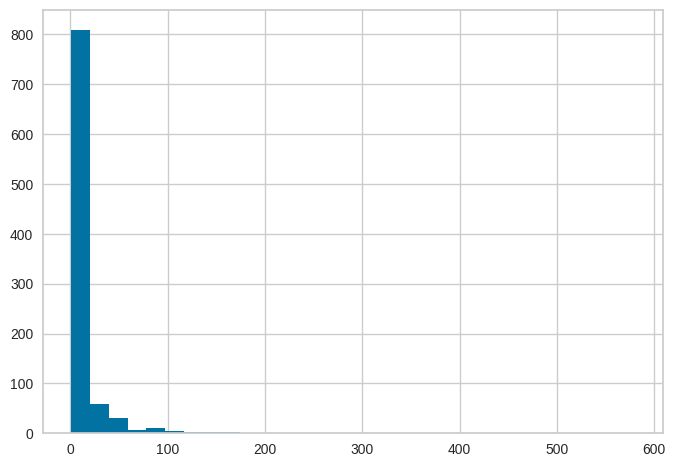

In [8]:
plt.hist(cal_cts, bins=30)

In [30]:
alpha = 0.1
qhats, preds, coverage_metrics, set_size_metrics = automatic_clustered_conformal(totalcal_scores_all, totalcal_labels,
                        alpha,
                        val_scores_all=val_scores_all, val_labels=val_labels, cluster='always')

Heuristic chose n_clustering=5, num_clusters=2
> /home/tding/code/class-conditional-conformal/utils/conformal_utils.py(304)clustered_conformal()
    302 
    303     # Print cluster sizes
--> 304     print(f'Cluster sizes:', [x[1] for x in Counter(cluster_assignments).most_common()])
    305 
    306     # 3) Compute qhats for each cluster

ipdb> cluster_assignments
array([1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1], dtype=int32)
ipdb> c
Cluster sizes: [62, 38]


In [ ]:
# TEST ! 

In [104]:
dataset = 'cifar-100'
save_folder = 'EXPERIMENT_TEST'
alpha = .1
n_totalcal = 10
score_function_list = ['softmax', 'APS']
methods = ['classwise', 'classwise_default_standard', 'always_cluster']
# methods = ['standard', 'classwise', 'classwise_default_standard', 'always_cluster']
# methods = ['standard']
seeds = [0, 1]

run_one_experiment(dataset, save_folder, 
                   alpha, n_totalcal, score_function_list, methods, seeds, save_preds=False)

softmax_scores shape: (18000, 100)
====== score_function=softmax ======
Computing conformal score...

seed=0
> /home/tding/code/class-conditional-conformal/utils/experiment_utils.py(81)run_one_experiment()
     79             save_to = os.path.join(curr_folder, f'seed={seed}_allresults.pkl')
     80             pdb.set_trace()
---> 81             if os.path.exists(save_to):
     82                 with open(save_to,'rb') as f:
     83                     all_results = pickle.load(f)

ipdb> q


In [103]:
pth = 'EXPERIMENT_TEST/n_totalcal=10/score=softmax/seed=1_allresults.pkl'

with open(pth, 'rb') as f:
    results = pickle.load(f)

for method in results.keys():
    print(method, results[method][2]['mean_class_cov_gap'])

standard 0.04035965853967319
classwise 0.0736457213466084
classwise_default_standard 0.05187659120176505
always_cluster 0.0402824946796642


In [105]:
totalcal_labels

array([1042,  458,  600, ...,  150,  130,  983])

In [106]:
cts = Counter(totalcal_labels)

In [108]:
cts[157]

188

In [308]:
dataset = 'inaturalist'

softmax_scores, labels = load_dataset(dataset)

softmax_scores shape: (1393421, 1103)


In [309]:
# Filter out classes with fewer than 150 examples
def remove_rare_classes(softmax_scores, labels, thresh = 150):
    '''
    Should apply to raw softmax scores instead of 1-softmax
    '''
    classes, cts = np.unique(labels, return_counts=True)
    non_rare_classes = classes[cts > thresh]

    # Filter labels and re-index
    remaining_label_idx = np.isin(labels, non_rare_classes)
#     pdb.set_trace()
    labels = labels[remaining_label_idx]
    new_idx = 0
    mapping = {} # old to new
    for i, label in enumerate(labels):
        if label not in mapping:
            mapping[label] = new_idx
            new_idx += 1
        labels[i] = mapping[label]
    
    # Remove rows and columns corresponding to rare classes from scores matrix
    softmax_scores = softmax_scores[remaining_label_idx,:]
    new_softmax_scores = np.zeros((len(labels), len(non_rare_classes)))
    for k in non_rare_classes:
        new_softmax_scores[:, mapping[k]] = softmax_scores[:,k]
    
    # Renormalize each row to sum to 1 
    new_softmax_scores = new_softmax_scores / np.expand_dims(np.sum(new_softmax_scores, axis=1), axis=1)

    return new_softmax_scores, labels


softmax_scores, labels = remove_rare_classes(softmax_scores, labels, thresh = 150)

In [310]:
scores_all = 1 - softmax_scores

In [311]:
scores_all.shape

(1393421, 1103)

In [312]:
labels.shape

(1393421,)

In [313]:
cts = Counter(labels).most_common()
cts[-20:]

[(216, 85),
 (836, 85),
 (858, 85),
 (540, 84),
 (671, 84),
 (1095, 84),
 (1101, 84),
 (668, 82),
 (1073, 82),
 (1100, 82),
 (916, 81),
 (109, 80),
 (748, 80),
 (1045, 80),
 (601, 79),
 (760, 78),
 (822, 78),
 (259, 76),
 (1065, 74),
 (902, 73)]

In [314]:
len(cts)

1103

In [315]:
sum(np.array(list(Counter(labels).values())) > 150)

872

In [328]:
n_avg = 30
totalcal_scores_all, totalcal_labels, val_scores_all, val_labels = random_split(scores_all, 
                              labels, 
                              n_avg, seed=0)

In [329]:
totalcal_scores_all.shape

(33090, 1103)

In [330]:
totalcal_labels.shape

(33090,)

In [331]:
max(totalcal_labels)

1102

In [344]:
alpha = 0.1
qhats, preds, coverage_metrics, set_size_metrics = clustered_conformal(totalcal_scores_all, totalcal_labels,
                        alpha,
                        val_scores_all=val_scores_all, val_labels=val_labels, split='proportional')

Excluding 578 rare classes from clustering
Cluster sizes: [264, 137, 104]


In [345]:
coverage_metrics

{'mean_class_cov_gap': 0.1021393580999638,
 'undercov_gap': 0.1303435252526181,
 'overcov_gap': 0.03675182481719495,
 'max_gap': 0.7641975308641975,
 'very_undercovered': 0.3354487760652765,
 'marginal_cov': 0.8862989963472125,
 'raw_class_coverages': array([0.89680715, 0.97692362, 0.95856358, ..., 0.13580247, 0.68292683,
        0.81904762]),
 'cluster_assignments': array([ 1,  0,  2, ..., -1, -1, -1])}

In [346]:
qhats2, preds2, coverage_metrics2, set_size_metrics2 = standard_conformal_pipeline(totalcal_scores_all, totalcal_labels, val_scores_all, val_labels, alpha)

In [347]:
coverage_metrics2

{'mean_class_cov_gap': 0.09110764613356194,
 'undercov_gap': 0.11859745644153873,
 'overcov_gap': 0.03479783009943476,
 'max_gap': 0.7518518518518519,
 'very_undercovered': 0.2828649138712602,
 'marginal_cov': 0.8983350375754137,
 'raw_class_coverages': array([0.91264368, 0.97359666, 0.96127437, ..., 0.14814815, 0.69512195,
        0.81904762]),
 'cluster_assignments': None}

In [337]:
np.unique(coverage_metrics['cluster_assignments'], return_counts=True)

(array([-1,  0,  1,  2]), array([598, 104, 264, 137]))

In [338]:
set_size_metrics

{'mean': 3.196588918432352,
 '[.25, .5, .75, .9] quantiles': array([1., 3., 5., 7.])}

In [339]:
set_size_metrics2

{'mean': 3.5074147395009008,
 '[.25, .5, .75, .9] quantiles': array([1., 3., 5., 7.])}

# Implement "Empirical Bayes"/regularized class-wise

shrinkage for a given class is dependent on number of examples from that class

In [377]:
# baseline, no reg
qhats3, preds3, coverage_metrics3, set_size_metrics3 = classwise_conformal_pipeline(totalcal_scores_all, totalcal_labels, val_scores_all, val_labels, alpha, 
                                 default_qhat=np.inf, regularize=False)




Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/tding/miniconda3/envs/py3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_1550983/222130321.py", line 2, in <module>
    qhats3, preds3, coverage_metrics3, set_size_metrics3 = classwise_conformal_pipeline(totalcal_scores_all, totalcal_labels, val_scores_all, val_labels, alpha,
  File "/home/tding/code/class-conditional-conformal/utils/conformal_utils.py", line 299, in classwise_conformal_pipeline
    classwise_preds = create_cb_prediction_sets(val_scores_all, classwise_qhats)
  File "/home/tding/code/class-conditional-conformal/utils/conformal_utils.py", line 279, in create_cb_prediction_sets
    class_scores = np.array(class_scores)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/tding/miniconda3/envs/py3.9/lib/python3.9/site-packages

In [372]:
coverage_metrics3

{'mean_class_cov_gap': 0.07551127962350268,
 'undercov_gap': 0.045502802424390566,
 'overcov_gap': 0.0808384667666561,
 'max_gap': 0.2566433566433567,
 'very_undercovered': 0.016319129646418858,
 'marginal_cov': 0.9146001965698054,
 'raw_class_coverages': array([0.89808429, 0.88610462, 0.91277797, ..., 1.        , 1.        ,
        1.        ]),
 'cluster_assignments': None}

In [392]:
qhats4, preds4, coverage_metrics4, set_size_metrics4 = classwise_conformal_pipeline(totalcal_scores_all, totalcal_labels, val_scores_all, val_labels, alpha, 
                                 default_qhat='standard', regularize=True)

SHRINKAGE FACTOR: [1.   1.   1.   ... 0.03 0.06 0.06]
0.03 1.0
Applying additive adjustment to qhats

Current adjustment: 0.500000
Marginal coverage: 0.9940
Search range: [0, 0.5]

Current adjustment: 0.250000
Marginal coverage: 0.9900
Search range: [0, 0.25]

Current adjustment: 0.125000
Marginal coverage: 0.9870
Search range: [0, 0.125]

Current adjustment: 0.062500
Marginal coverage: 0.9770
Search range: [0, 0.0625]

Current adjustment: 0.031250
Marginal coverage: 0.9580
Search range: [0, 0.03125]

Current adjustment: 0.015625
Marginal coverage: 0.9290
Search range: [0, 0.015625]

Current adjustment: 0.007812
Marginal coverage: 0.9160
Search range: [0, 0.0078125]

Current adjustment: 0.003906


Marginal coverage: 0.9100
Search range: [0, 0.00390625]

Current adjustment: 0.001953
Marginal coverage: 0.9050
Search range: [0, 0.001953125]

Current adjustment: 0.000977
Marginal coverage: 0.9030
Search range: [0, 0.0009765625]

Current adjustment: 0.000488
Marginal coverage: 0.9030
Search range: [0, 0.00048828125]

Current adjustment: 0.000244
Marginal coverage: 0.9030
Search range: [0, 0.000244140625]

Current adjustment: 0.000122
Marginal coverage: 0.9030
Search range: [0, 0.0001220703125]

Current adjustment: 0.000061
Marginal coverage: 0.9010
Search range: [0, 6.103515625e-05]

Current adjustment: 0.000031
Marginal coverage: 0.9010
Search range: [0, 3.0517578125e-05]

Current adjustment: 0.000015
Marginal coverage: 0.9010
Search range: [0, 1.52587890625e-05]

Current adjustment: 0.000008
Marginal coverage: 0.9010
Search range: [0, 7.62939453125e-06]
Adequate precision reached; stopping early.
Final adjustment: 7.62939453125e-06


In [383]:
coverage_metrics4

{'mean_class_cov_gap': 0.0817299495159421,
 'undercov_gap': 0.11113765984673624,
 'overcov_gap': 0.03132144543928147,
 'max_gap': 0.7518518518518519,
 'very_undercovered': 0.24025385312783318,
 'marginal_cov': 0.8934965093054558,
 'raw_class_coverages': array([0.89808429, 0.88610462, 0.91277797, ..., 0.14814815, 0.69512195,
        0.81904762]),
 'cluster_assignments': None}

In [393]:
coverage_metrics4

{'mean_class_cov_gap': 0.08260535481904063,
 'undercov_gap': 0.11084295195164225,
 'overcov_gap': 0.0325864955766182,
 'max_gap': 0.7518518518518519,
 'very_undercovered': 0.2411604714415231,
 'marginal_cov': 0.8935354704112455,
 'raw_class_coverages': array([0.89782886, 0.88610462, 0.91183962, ..., 0.14814815, 0.69512195,
        0.81904762]),
 'cluster_assignments': None}

In [384]:
set_size_metrics3

{'mean': 607.3126246479717,
 '[.25, .5, .75, .9] quantiles': array([601., 604., 611., 621.])}

In [385]:
set_size_metrics4

{'mean': 4.566646647029289,
 '[.25, .5, .75, .9] quantiles': array([ 1.,  3.,  7., 11.])}

In [6]:
pth = '.cache/paper/varying_n/inaturalist/n_totalcal=30/score=softmax/seed=0_allresults.pkl'
with open(pth, 'rb') as f:
    results = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: '.cache/paper/varying_n/inaturalist/n_totalcal=30/score=softmax/seed=0_allresults.pkl'

In [4]:
results.keys()

dict_keys(['standard', 'classwise', 'classwise_default_standard', 'cluster_balanced', 'cluster_proportional', 'cluster_doubledip', 'regularized_classwise'])

In [5]:
results['regularized_classwise']

(array([0.97739856, 0.99953436, 0.99981116, 0.99990067, 0.99980282,
        0.91465062, 0.99976321, 0.99990056, 0.99747161, 0.99994817,
        0.99966858, 0.99983143, 0.9997904 , 0.99978816, 0.99921132,
        0.99962898, 0.99909807, 0.95782454, 0.99981571, 0.99958002,
        0.87995997, 0.99967608, 0.99979758, 0.99910414, 0.97882278,
        0.9997989 , 0.99973787, 0.99942885, 0.99657893, 0.99965588,
        0.98912544, 0.99974533, 0.99995298, 0.99943369, 0.99982143,
        0.99978952, 0.99946662, 0.99978911, 0.99984529, 0.52232238,
        0.99979523, 0.99977914, 0.99956474, 0.9998146 , 0.99976494,
        0.99980735, 0.99979754, 0.99988056, 0.9557152 , 0.99898932,
        0.99657432, 0.99976321, 0.99936717, 0.72199546, 0.99927022,
        0.99978618, 0.99969902, 0.99924864, 0.99368329, 0.99965863,
        0.99972607, 0.9990218 , 0.99966115, 0.9997416 , 0.9998546 ,
        0.99972045, 0.99961743, 0.99985748, 0.99882606, 0.99819734,
        0.9989382 , 0.99846066, 0.9998871 , 0.99

In [7]:
N = 10
K = 1000
int(N*K/(75+K))

9

In [8]:
K/(75+K)

0.9302325581395349

In [12]:
dataset = 'imagenet'
n_totalcal = 10
alpha = .1
score_function_list = ['softmax']
methods = ['cluster_proportional']
seeds = [0]

run_one_experiment(dataset, '.cache/paper/varying_n', alpha, n_totalcal, 
                   score_function_list, methods, seeds, save_preds=False)

softmax_scores shape: (1153051, 1000)
====== score_function=softmax ======
Computing conformal score...

seed=0
Loaded existing results file containing results for ['standard', 'classwise', 'classwise_default_standard', 'cluster_balanced', 'cluster_proportional', 'cluster_doubledip', 'regularized_classwise']
Class counts range from 1 to 20
dataset=imagenet, n=10,score_function=softmax, seed=0, method=cluster_proportional
Excluding 333 rare classes from clustering
n_clustering=8, num_clusters=4
Cluster sizes: [192, 175, 162, 138]
Saved results to .cache/paper/varying_n/imagenet/n_totalcal=10/score=softmax/seed=0_allresults.pkl


In [13]:
pth = '.cache/paper/varying_n/imagenet/n_totalcal=10/score=softmax/seed=0_allresults.pkl'

with open(pth, 'rb') as f:
    results = pickle.load(f)

In [17]:
for seed in range(10):
    print(f'\nseed={seed}')
    
    pth = f'.cache/paper/varying_n/imagenet/n_totalcal=30/score=softmax/seed={seed}_allresults.pkl'

    with open(pth, 'rb') as f:
        results = pickle.load(f)

    for key, val in results.items():
        print(key)
        print(val[2]['mean_class_cov_gap'])


seed=0
standard
0.053233331744685225
classwise
0.043055683220962745
classwise_default_standard
0.043055683220962745
cluster_balanced
0.049841830243581714
cluster_proportional
0.049064450805325524
cluster_doubledip
0.05390128591358193
regularized_classwise
0.04226097415782523

seed=1
standard
0.05208742187163091
classwise
0.04274758746954129
classwise_default_standard
0.04274758746954129
cluster_balanced
0.051986223464971296
cluster_proportional
0.046137458089478736
cluster_doubledip
0.051851372676974
regularized_classwise
0.035764220166448854

seed=2
standard
0.05278059883655533
classwise
0.04407352440360456
classwise_default_standard
0.04407352440360456
cluster_balanced
0.04940379972268535
cluster_proportional
0.047998348247247816
cluster_doubledip
0.050882404560078885
regularized_classwise
0.0376266080230506

seed=3
standard
0.052140376964411615
classwise
0.0424078975987832
classwise_default_standard
0.0424078975987832
cluster_balanced
0.055206697545092095
cluster_proportional
0.046

In [18]:
pth = f'.cache/paper/varying_n/imagenet/n_totalcal=75/score=softmax/seed=0_allresults.pkl'

with open(pth, 'rb') as f:
    results = pickle.load(f)

for key, val in results.items():
    print(key)
    print(val[2]['mean_class_cov_gap'])

standard
0.05325447417292449
classwise
0.027995078971249816
classwise_default_standard
0.027995078971249816
cluster_balanced
0.05410476311654733
cluster_proportional
0.05438811683751035
cluster_doubledip
0.053059502882896514
regularized_classwise
0.030151463980699005


In [27]:
pth = f'.cache/paper/varying_n/places365/random_calset/n_totalcal=10/score=softmax/seed=0_allresults.pkl'

with open(pth, 'rb') as f:
    results = pickle.load(f)

# for key, val in results.items():
#     print(key)
#     print(val[2]['mean_class_cov_gap'], val[2]['num_unclustered_classes'])

results['cluster_proportional'][2]['num_unclustered_classes']

125

In [25]:
pth = f'.cache/paper/varying_n/inaturalist/random_calset/n_totalcal=10/score=softmax/seed=0_allresults.pkl'

with open(pth, 'rb') as f:
    results = pickle.load(f)

for key, val in results.items():
    print(key)
    print(val[2]['mean_class_cov_gap'])

standard
0.07650551506192214
classwise
0.08769909819029488
cluster_proportional
0.18116020971353544
cluster_doubledip
0.23937345539443325
regularized_classwise
0.06180823358267488


In [29]:
a = np.array([1,2,3])
np.concatenate((a, [4]))

array([1, 2, 3, 4])